#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of ORIGINAL Submission: 9:00 AM EST, Thursday, March 10, 2016  
Time of Resubmission: 10:20 AM EST, Saturday, March 12, 2016  
W261-3, Spring 2016  
Week 7 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW7/MIDS-W261-2015-HWK-Week07-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/s/26ejqhkzqdidzwj/HW7-Questions.txt?dl=0)**


In [62]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
#Use this line of code to kick off a persistent cluster
!python -m mrjob.tools.emr.create_job_flow '--conf-path' 'mrjob.conf'

creating new scratch bucket mrjob-a9a7d2100079455f
using s3://mrjob-a9a7d2100079455f/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160312.024137.341853
writing master bootstrap script to /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160312.024137.341853/b.py
creating S3 bucket 'mrjob-a9a7d2100079455f' to use as scratch space
Copying non-input files into s3://mrjob-a9a7d2100079455f/tmp/no_script.nicholashamlin.20160312.024137.341853/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-2VQKH4YTSZQSY
j-2VQKH4YTSZQSY


## HW 7.0

### HW 7.0 - Problem Statement
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

### HW 7.0 - MR job definition
For brevity, we've combined the initialization step and the main job into a single unit of code.  During the first pass, we check to make sure each node has been properly initialized and, if not, initialize it.  

In [337]:
%%writefile MRbfs.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import re
import ast

WORD_RE = re.compile(r"[\w']+")
 
class MRbfs(MRJob):

        
    def configure_options(self):
        super(MRbfs, self).configure_options()
        self.add_passthrough_option('--start', default='1', type=str)
        self.add_passthrough_option('--end', default='4', type=str)
        self.add_passthrough_option('--statuspath', default='', type=str)
        self.add_passthrough_option('--iteration', default='1', type=str)
        self.add_passthrough_option('--jobtype', default='local', type=str)

        
    def mapper(self, node, line):
        if self.options.iteration=='1':
            line = line.strip('\n')
            data = line.split("\t")
            status = 'U' #everything is unvisited initially

            # This is the first inialization (from original graph file)
            # there are only 2 elements, the node and adjacency list
            if(len(data) == 2): 
                nid = data[0]
                N = ast.literal_eval(data[1])

                # if our node is the start node , initialize the start
                # distance at source = 0.0
                if nid == self.options.start:
                    ds = 0.0
                    status = 'V'
                    path=[nid]
                else: 
                    # if this is not the start node, intialize distance to inf and path to empty list
                    ds = float("inf")
                    path=[]

                # yield the root node , (distance, graph structure, status, "Visited", and path (as a list))
                yield  nid, (ds, N, status,path)

                # nor each of the nodes in the adjacency list, 
                # we expand frontier with starting distance.
                for m,d in N.iteritems():
                    #new distance is going to be from root node  + dist              
                    newdist = d+ds
                    new_path=path[:]
                    new_path.append(m)
                    if newdist < float("inf"):
                        status = 'Q'

                    yield m, (newdist, None, status,new_path)
                
        # from Iteration 1 onwards we'll land here...more data items to track
        else:
            if self.options.jobtype=='local':
                inf=float("inf") #THIS IS A TERRIBLE HACKJOB that lets us deal with string/inf eval weirdness
                line = line.strip('\n')
                nid,data=eval(line)
            
            if self.options.jobtype=='emr':
                Infinity=float('inf') #SEE HACKJOB ABOVE
                line = line.strip('\n')
                nid,data=line.split('\t')
                nid=eval(nid)
                data=eval(data)
            
            
            dist=data[0]
            N = data[1] # adjacency list - graph to use for next iter
            status = data[2] #status - U, Q, V
            path=data[3] #list of previously visited nodes
            
              
            #If a node is in the frontier, expand it
            if status=='Q':
                #Emit original node
                yield  nid, (dist, N, 'V',path)
                
                #Emit linked nodes
                for m,d in N.iteritems():
                    newdist=d+dist
                    new_path=path[:]
                    new_path.append(m)
                    yield m, (newdist, None, 'Q', new_path)
            
            #If it's not in the frontier, pass it through unchanged
            else:        
                yield  nid, (dist, N, status,path)
                    
                    
    def reducer_init(self):
        """We originally used these values for playing with
        alternative implementations of the stopping condition, but
        they're not really needed in the final version"""
        self.finished=0
        self.shortest_path=[]
        self.min_dist=0
            
    def reducer(self, node, distances):
        adjList = {} #adjacency list - to be compiled below
        sdist = float("inf") #this is the shortest distance we've seen to the node so far
        stati = [] #list of all statuses we've encountered for this node
        spath=[] #shortest path we've found to the node so far
        for dist in distances:
            node_dist,list_of_links,temp_status,path=dist[:]

            # Extract the original graph structure from the node that has it
            if list_of_links:
                adjList = list_of_links
            
            stati.append(temp_status)
            
            #If we find a record of a visited node, we can move on
            if temp_status == 'V':
                sdist=node_dist
                spath = path
                break
                       
            # If we find a shorter distance to a node, update our knowledge of it
            if node_dist < sdist:
                sdist = node_dist
                spath=path
                if node not in spath:
                    spath.append(node)
            
        #Check the current state of the node
        if 'V' in stati:
            status='V'
            #Have we hit our destination node?
            if node==self.options.end :
                self.shortest_path=spath
                self.finished=1
                self.min_dist=sdist
        elif 'Q' in stati:
            status='Q'
        else:
            status='U'
            
        yield node, (sdist, adjList, status, spath)
        
    def steps(self):
        return [MRStep( 
                        mapper=self.mapper
                        ,reducer_init=self.reducer_init
                        ,reducer=self.reducer
                      )]
    
if __name__ == '__main__':
    MRbfs.run()

Overwriting MRbfs.py


### HW 7.0 - Undirected Toy Test

In [6]:
## HW7 - Undirected Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='undirected_toy'
start_node='1'
end_node='4'


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case

while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
DONE
Shortest path from 1 to 4 is 2 steps long:
The path is:  ['1', '2', '4']


### HW 7.0 - Directed Toy Test

In [5]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='directed_toy'
start_node='1'
end_node='5'

#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case

while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 1 to 5 is 3 steps long:
The path is:  ['1', '2', '4', '5']


##HW7.1 

### HW 7.1 Problem Statement

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

### HW 7.1 Calculating Summary Statistics

Here, we take a simple pairs approach to count nodes and edges:

In [22]:
%%writefile mrexplorenltk.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
from operator import itemgetter
import re
import ast

class mrExploreNLTKTotals(MRJob):
            
    def mapper(self, _, line):
        """Emit keyless records (since we don't want to group our results)
        Values are (1,node_degree)"""
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        node_degree = len(N)
        yield _,(1,node_degree)

        
    def reducer(self, nid, line):
        """Aggregate node counts and degree counts"""
        nodes=0
        edges=0
        for record in line:
            nodes+=record[0]
            edges+=record[1]    
        yield None, (nodes,edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrExploreNLTKTotals.run()

Overwriting mrexplorenltk.py


In [68]:
#HW 7.1 - Calculating summary stats on NLTK data locally
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrExploreNLTKTotals

mr_job = mrExploreNLTKTotals(args=['synNet.txt','--no-strict-protocols'])
nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        #This performs the same function as the reducer, which is needed to calculate the
        #final totals across a larger cluster.  It's not really important for local use, 
        #but we'll need it for EMR
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total Nodes = {}".format(nodes)   
print "Total Edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)
                

Total Nodes = 8271
Total Edges = 61134
Average Edges/Node = 7.39136742836


### HW 7.1 - Plotting the degree distribution

This second (very simple job) returns counts of nodes bucketed by how many degrees they have so that the distribution can be easily visualized.

In [76]:
%%writefile mrexplorenltkdist.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
from operator import itemgetter
import re
import ast

class mrExploreNLTKDist(MRJob):
            
    def mapper(self, _, line):
        """Emit one record per node:
        Key: The node's degree (with padded zeros)
        Value: 1
        """
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        if N:
            node_degree = len(N)
        else:
            node_degree=0
        #Padding the degrees with leading zeros gives us results in order nicely
        yield '{0:010d}'.format(node_degree), 1

    def reducer(self, degree, count):
        """Aggregate pairs returned by the mapper"""
        total_nodes=sum([i for i in count])  
        yield degree, total_nodes
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrExploreNLTKDist.run()

Overwriting mrexplorenltkdist.py


In [77]:
#HW 7.1 - Calculating degree distribution on NLTK data locally
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltkdist import mrExploreNLTKDist

input_dir_prefix='synNet'

mr_job = mrExploreNLTKDist(args=['{0}.txt'.format(input_dir_prefix),'--no-strict-protocols'])
nodes=0
edges=0
with open ('{0}_degree_distribution.txt'.format(input_dir_prefix),'w') as f:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            #Write results to a file so we can plot them more easily
            f.writelines(line)

print "Done"

Done


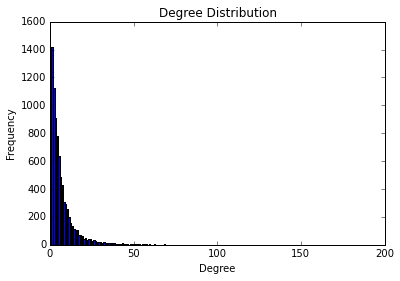

In [78]:
# HW 7.1 - Plot the results of the distribution
x=[]
y=[]
with open ('{0}_degree_distribution.txt'.format(input_dir_prefix),'r') as f:
    for line in f.readlines():
        data=line.strip('\n').split('\t')
        degree=int(eval(data[0]))
        count=int(data[1])
        x.append(degree)
        y.append(count)

plt.bar(x,y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

As we'd expect, the distribution of degree does follow a power law; there are a handful of pages that are widely linked and lots of pages that have very few links.

### HW 7.1 - Testing on EMR with the same dataset
The only changes here are to the job parameters, but we've rerun everything to ensure that it will work properly in the cloud for 7.3 below.

In [82]:
#HW 7.1 - Calculating summary stats on NLTK data in EMR
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrExploreNLTKTotals

input_dir_prefix='synNet'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
cluster='j-2VQKH4YTSZQSY'

#EMR VERSION
mr_job = mrExploreNLTKTotals(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'EDAOutput',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total Nodes = {}".format(nodes)   
print "Total Edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)
                

Total Nodes = 8271
Total Edges = 61134
Average Edges/Node = 7.39136742836


In [80]:
# HW 7.1 - Calculating degree distribution of NLTK data in EMR
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltkdist import mrExploreNLTKDist

input_dir_prefix='synNet'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
cluster='j-2VQKH4YTSZQSY'

#EMR VERSION
mr_job = mrExploreNLTKDist(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'DistOutput',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

with open ('{0}_degree_distribution_EMR.txt'.format(input_dir_prefix),'w') as f:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            #Write results to a file so we can plot them more easily
            f.writelines(line)

print "Done"

Done


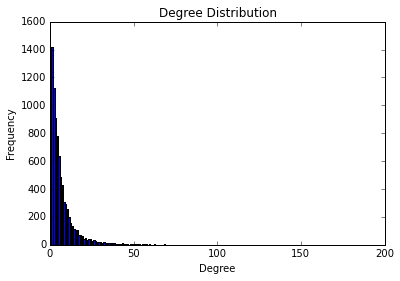

In [81]:
# HW 7.1 - Plot the results of the EMR-generated distribution
x=[]
y=[]
with open ('{0}_degree_distribution.txt'.format(input_dir_prefix),'r') as f:
    for line in f.readlines():
        data=line.strip('\n').split('\t')
        degree=int(eval(data[0]))
        count=int(data[1])
        x.append(degree)
        y.append(count)

plt.bar(x,y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

##HW7.2

### HW 7.2 Problem Statement

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

### HW 7.2 Implementation

In [339]:
## HW7 - NLTK Example, running locally 
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'
end_node='536'


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRbfs(args=[input_directory, 
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '1426', '1668', '536']


In [344]:
# NLTK example, running in EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division

iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-2MM2A2KMPDLBH'

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'
end_node='536'

#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):

    if iterate==1:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True
            if nid==end_node:
                break
            
        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '1426', '1688', '536']


##HW7.3 

### HW 7.3 Problem Statement
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

### HW 7.3 Implementation
The directed toy systems test is shown above in the results for 7.1, so for we have not repeated it here.  Running our EDA code on the full dataset just requires updating the input data, so very little needs to change here.

In [83]:
# HW 7.3 - Calculating summary stats on full Wikipedia dataset
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrExploreNLTKTotals

input_dir_prefix='all-pages-indexed-out'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
cluster='j-2VQKH4YTSZQSY'


#EMR VERSION
mr_job = mrExploreNLTKTotals(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://hamlin-mids-261/WikiEDAOutput',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total Nodes = {}".format(nodes)   
print "Total Edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)
                

Total Nodes = 5781290
Total Edges = 142114057
Average Edges/Node = 24.5817208616


In [84]:
# HW 7.3 - Calculating degree distribution on full Wikipedia dataset
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltkdist import mrExploreNLTKDist


input_dir_prefix='all-pages-indexed-out'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
cluster='j-2VQKH4YTSZQSY'

#EMR VERSION
mr_job = mrExploreNLTKDist(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://hamlin-mids-261/WikiDistOutput',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

with open ('{0}_degree_distribution_EMR.txt'.format(input_dir_prefix),'w') as f:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            #Write results to a file so we can plot them more easily
            f.writelines(line)

print "Done"

Done


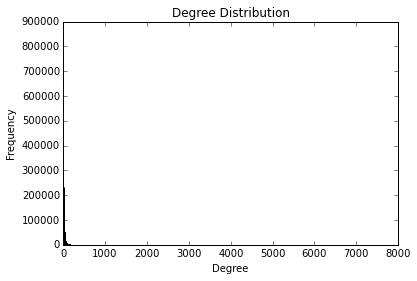

In [85]:
# HW 7.3 - Plot the results of the distribution
x=[]
y=[]
with open ('{0}_degree_distribution_EMR.txt'.format(input_dir_prefix),'r') as f:
    for line in f.readlines():
        data=line.strip('\n').split('\t')
        degree=int(eval(data[0]))
        count=int(data[1])
        x.append(degree)
        y.append(count)
        #print degree,count

plt.bar(x,y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

Here, we see the general shape of the plot looks similar to what we saw in 7.1, but with an even more extreme power law curve.  This is because we're dramatically increasing the size of the data, which means that the most linked pages will have even more links and there will be fewer of them relative to the rest of the population.

Initially our implementation in 7.1 did not scale particularly well and kept crashing our notebook.  However, once we refactored the EDA process into two separate jobs we were able to optimize both of them independently. This version scaled much better, generating the results shown above in just a few minutes.

##HW 7.4

### HW 7.4 - Problem Statement

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

### HW 7.4 - Running the directed toy example on EMR

In [326]:
# HW 7.4 - Directed toy example with FULL output, running on EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division
                              
iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-3AH5RMM6FM1X7'

#### TEST VERSION #####
input_dir_prefix='testgraph'
start_node='1'
end_node='5'

#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            print nid, status, path
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True 
        print ""
            
        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
1 V ['1']
2 Q ['1', '2']
3 U []
4 U []
5 U []
6 Q ['1', '6']

Iteration : 2
1 V ['1']
2 V ['1', '2']
3 Q ['1', '2', '3']
4 Q ['1', '2', '4']
5 U []
6 V ['1', '6']

Iteration : 3
1 V ['1']
2 V ['1', '2']
3 V ['1', '2', '3']
4 Q ['1', '2', '4']
5 Q ['1', '2', '4', '5']
6 V ['1', '6']

Iteration : 4
1 V ['1']
2 Q ['1', '2']
3 V ['1', '2', '3']
4 V ['1', '2', '4']
5 Q ['1', '2', '4', '5']
6 V ['1', '6']

Iteration : 5
1 V ['1']
2 Q ['1', '2']
3 Q ['1', '2', '3']
4 Q ['1', '2', '4']
5 V ['1', '2', '4', '5']
DONE
Shortest path from 1 to 5 is 3 steps long:
The path is:  ['1', '2', '4', '5']
6 V ['1', '6']



Having confirmed that this works in the cloud, now let's run it on the entire dataset

### HW 7.4  - Full-scale Implementation

In [93]:
# HW 7.4 - Load index into memory so we can look things up
word_dict={}
node_dict={}
with open('./wikipedia/indices.txt') as f:
    for line in f.readlines():
        word,node_id,_,_=line.strip().split('\t')
        node_dict[node_id]=word #Enables us to find words by ID
        word_dict[word]=node_id #Enables us to find IDs by word

In [106]:
# HW 7.4 - Full Wikipedia data, running in EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division

iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-2VQKH4YTSZQSY'

#### WIKIPEDIA VERSION #####
input_dir_prefix='wiki'
start_node='6176135'
end_node='13466359'


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://hamlin-mids-261/all-pages-indexed-out.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         #'--pool-emr-job-flows',#
                         #'--max-hours-idle', '1',#
                         #'--num-ec2-instances', '4',#
                         #'--ec2-instance-type', 'm3.xlarge',#
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            
            #If we've hit our stopping condition, print results and finish up
            if nid==end_node and status=='V':
                word_path=[node_dict[word]+' ('+word+')' for word in path]
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(node_dict[start_node],node_dict[end_node],str(len(path)-1))
                print "The path is: \n",' ->\n'.join(word_path)
                stop=True
            if nid==end_node:
                break
        #Keep track of which iteration we're on
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
DONE
Shortest path from Ireland to University of California, Berkeley is 2 steps long:
The path is: 
Ireland (6176135) ->
Seamus Heaney (11607791) ->
University of California, Berkeley (13466359)


Sure enough, we find only two steps are required to traverse from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359).  One of the big performance quirks we noticed is the need to stream data from the S3 bucket on the west coast to our EMR cluster on the east coast.  After realizing how long this was taking in the initial transfer, we found it to be more efficient to simply reupload the dataset to a bucket in the east to minimize the delay.

Now let's try running on another path, just to see what happens:

In [110]:
# HW 7.4- Lookup ID numbers for some random pages that sound interesting
print word_dict['Teenage Mutant Ninja Turtles']
print word_dict['Pi'] #March 14 is coming up...

12621471
10274977


In [111]:
# HW 7.4 - Full Wikipedia data, running in EMR
%reload_ext autoreload
%autoreload 2
from MRbfs import MRbfs
from __future__ import division

iterate = 1
stop = False

#PUT CLUSTER HERE!!!!!
cluster='j-2VQKH4YTSZQSY'

#### WIKIPEDIA VERSION #####
input_dir_prefix='wiki'
start_node='12621471'
end_node='10274977'


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://hamlin-mids-261/all-pages-indexed-out.txt'
    else:
        input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRbfs(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         #'--pool-emr-job-flows',#
                         #'--max-hours-idle', '1',#
                         #'--num-ec2-instances', '4',#
                         #'--ec2-instance-type', 'm3.xlarge',#
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            #print nid, status, path
            if nid==end_node and status=='V':
                word_path=[node_dict[word]+' ('+word+')' for word in path]
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(node_dict[start_node],node_dict[end_node],str(len(path)-1))
                print "The path is: \n",' ->\n'.join(word_path)
                stop=True
            if nid==end_node:
                break
            
        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from Teenage Mutant Ninja Turtles to Pi is 3 steps long:
The path is: 
Teenage Mutant Ninja Turtles (12621471) ->
Palladium Books (9937936) ->
Ancient Egypt (1110099) ->
Pi (10274977)


##HW 7.5

### HW 7.5 Problem Statement
Suppose you wanted to find the largest network distance from a single source,i.e., a node that is the furthest (but still reachable) from a single source. How would you implement this task? How is this different from finding the shortest path graph distances? Is this task more difficult to implement than the shortest path distance? As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

### HW 7.5 Response
We'd find the largest path using a similar, but not exactly the same, approach that we're using here to find the shortest path.  The key difference is that we know in advance that we'll need to thoroughly traverse the entire graph to know that we've found the longest path.  In our shortest path implementation, we stop when we've found the shortest path to the node we're interested in.  This meant that the task isn't necessarily more "difficult" from a logical perspective, but it may be more computationally intensive as it would likely require more iterations to arrive at a conclusion.  Since we know we'll need to run several more iterations (and can't take advantage of the "six-degrees-of-separation" effect that we can when we look for the shortest path), optimizing both our mapreduce implementation and our cluster infrastructure for rapid turnover is even more important when searching for the longest path.  It shouldn't matter whether we use a depth first search or a breadth first search, since we'll still need to visit every node regardless.


##HW 7.5.1: 
Can we utilize combiners in the HW 7 to perform the shortest path implementation?

**We could probably use combiners to handle some of the logic that's currently addressed in the reducer around deciding what state a node is in.  This might entail minimizing network throughput by using the combiner to decide not to emit records to the reducer nodes that have already been visited or to do some precalculation of the shortest path to a given node based only on the records available to that particular mapper.  These "subtotals" could then be reconciled in the reducer.**

Does order inversion help with the HW 7 shortest path implementation?

**We might be able to use order inversion to simplify some of the logic in the reducer by guaranteeing, for example, that the reducer would always receive the original record of a node before records corresponding to expanded links.  That said, while this might make the code easier to understand, it may not lead to a significant boost in performance.**



##End of Submission